# Breakout Strategy  

## Description of the project

In this project,  we are going to implement a Breakout trading strategy. We will find and remove any outliers. Then we will test to see if this strategy has the potential to be profitable using a Histogram and P-Value. 

To implement the strategy, we will select a universe of stock composed of 500 stocks with at least eight years of data and the highest average daily trading volume in dollar terms over the relevant period.


In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
idx = pd.IndexSlice
plt.style.use("seaborn")

## Market Data
### Load Data
The data we use for this project is end of day data. This contains data for many stocks, but we will systematically extract stocks with high liquidity. That means, we are going to use the universe of most traded stocks.

In [2]:
DATA_STORE = Path('stock_prices.h5')
with pd.HDFStore(DATA_STORE) as store:
    data = store[list(store.keys())[0]].loc[idx[:, '2006':'2016'], :]
data

open       high        low      close     volume
ticker date                                                             
A      2006-01-03  22.786839  22.909642  22.387796  22.855063  3796200.0
       2006-01-04  22.889175  23.080202  22.766372  22.916465  3001300.0
       2006-01-05  22.820951  23.516836  22.820951  23.516836  3458800.0
       2006-01-06  23.537304  23.735153  23.257585  23.639640  4396500.0
       2006-01-09  23.639640  23.741976  23.482724  23.571416  2920500.0
...                      ...        ...        ...        ...        ...
ZUMZ   2016-12-23  20.950000  21.500000  20.950000  21.350000   532292.0
       2016-12-27  21.200000  21.700000  21.200000  21.450000   308004.0
       2016-12-28  21.550000  21.749900  21.325000  21.450000   165827.0
       2016-12-29  21.550000  22.050000  21.400000  21.900000   322108.0
       2016-12-30  21.900000  22.190000  21.600000  21.850000   295429.0

[7531907 rows x 5 columns]

In [3]:
print(f"#Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

#Tickers: 3,186 | # Dates: 2,846


### Data cleaning
This is an important step before implementating any strategy as some data may exhibit outliers measured exceptionally high or low returns.

What we do is to compute daily returns of close prices and keep only inliers with values between chosen extrem values as a basic check against data error.

Then we choose to keep only returns between -71% and 189%. That means, we choose to consider the values outside of this range as outliers. 


In [4]:
daily_returns = data.groupby('ticker').close.pct_change()
outliers = daily_returns[(daily_returns < daily_returns.quantile(0.00001)) | (daily_returns > daily_returns.quantile(0.99999))]
data = data.drop(outliers.index.unique('ticker'), level='ticker')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7340162 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 308.8+ MB


### Select the universe of stocks to build our trading strategy.

We will select the 500 most-traded stocks prior to 2017. We will then Compute the dollar volume as the product of the adjusted close price and the adjusted volume:


In [5]:
dv = data.close.mul(data.volume)
selected500Stocks = dv.groupby(level='date').rank(ascending=False).unstack('ticker').dropna(thresh=8*252, axis=1).mean().nsmallest(500)

In [6]:
selected500Stocks.index

Index(['AAPL', 'GOOGL', 'MSFT', 'BAC', 'XOM', 'C', 'JPM', 'GE', 'INTC', 'CSCO',
       ...
       'THC', 'BMRN', 'WSM', 'CMS', 'IGT', 'CPN', 'NUAN', 'CYH', 'RSG', 'SM'],
      dtype='object', name='ticker', length=500)

In [7]:
to_drop = data.index.unique('ticker').difference(selected500Stocks.index)
data = data.drop(to_drop, level='ticker')

Here are the selected stocks we will work with

In [8]:
data.index.unique('ticker')

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACE', 'ACI', 'ACN', 'ADBE',
       ...
       'XEL', 'XL', 'XLNX', 'XOM', 'XRX', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZMH'],
      dtype='object', name='ticker', length=500)

In [9]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,769


In [10]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1366286 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1366286 non-null  float64
 1   high    1366286 non-null  float64
 2   low     1366286 non-null  float64
 3   close   1366286 non-null  float64
 4   volume  1366286 non-null  float64
dtypes: float64(5)
memory usage: 58.1+ MB


## Visualize a the highs and lows prices of a  chosen stock
Let's see what a single stock looks like from the high and low prices. For this example, we'll use Apple's stock (AAPL). If we tried to graph all the stocks, it would be too much information.

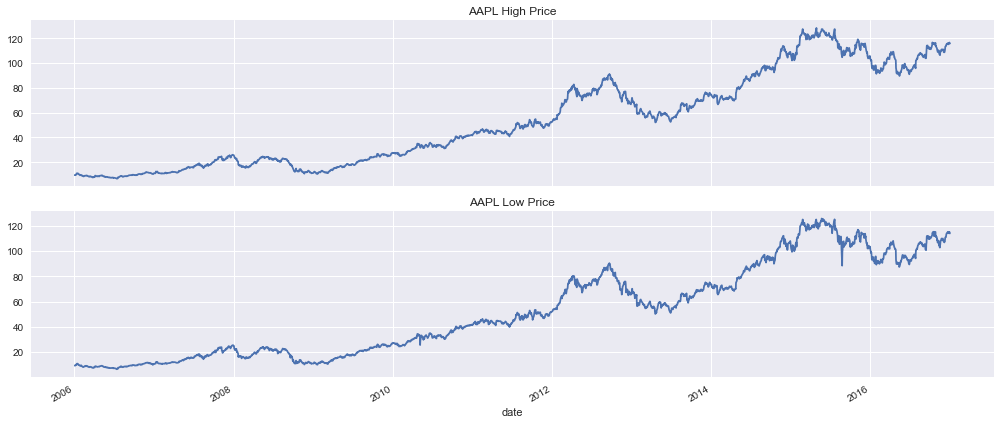

In [11]:
ticker = 'AAPL'
sample_high = data.loc[ticker, 'high']
sample_low = data.loc[ticker, 'low']


fig, axes = plt.subplots(nrows=2, figsize=(14, 6), sharex=True)
sample_high.plot(ax=axes[0], title=f'{ticker} High Price') # plot the closing prices 
sample_low.plot(ax=axes[1], title=f'{ticker} Low Price')
sns.despine()
fig.tight_layout()

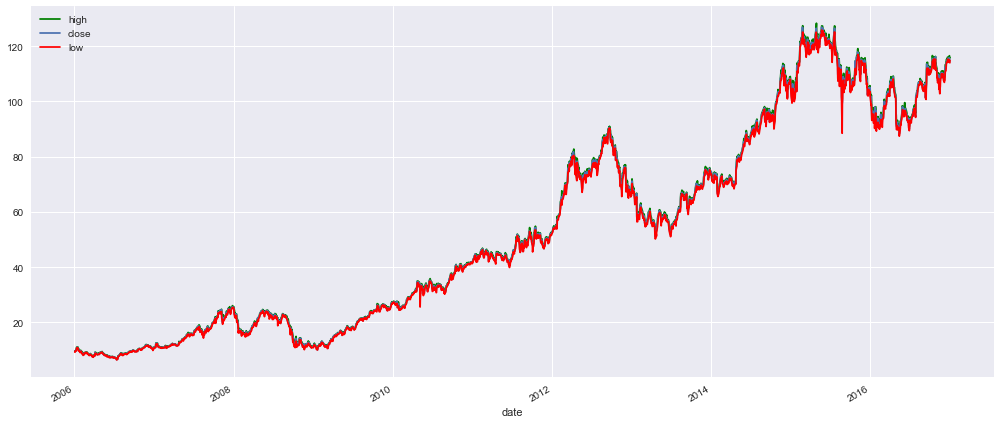

In [12]:
ticker = 'AAPL'
sample_high = data.loc[ticker, 'high']
sample_low = data.loc[ticker, 'low']
sample_close = data.loc[ticker, 'close']


fig, axes = plt.subplots(nrows=1, figsize=(14, 6), sharex=True)
sample_high.plot(ax=axes, color='g') # plot the closing prices 
sample_close.plot(ax=axes)
sample_low.plot(ax=axes, color='r')
plt.legend()
sns.despine()
fig.tight_layout()

Now we select the __high__ anf __low__ prices of all the selected stocks. In the remaining of this work, we will use those two  DataFram to build the Breakout Strategy.

In [13]:
high = data.high.unstack(level='ticker')
low = data.low.unstack(level='ticker')
close = data.close.unstack(level='ticker')

## The Alpha Research Process

In this project you will code and evaluate a "breakout" signal. 

Before we start coding and evaluating the Breakout Strategy, it is important to understand where these steps fit in the alpha research workflow. The signal-to-noise ratio in trading signals is very low and, as such, it is very easy to fall into the trap of _overfitting_ to noise. It is therefore inadvisable to jump right into signal coding. To help mitigate overfitting, it is best to start with a general observation and hypothesis; i.e., one should be able to answer the following question _before_ touching any data:

> What feature of markets or investor behaviour would lead to a persistent anomaly that my signal will try to use?

Ideally the assumptions behind the hypothesis will be testable _before_  we actually code and evaluate the signal itself. The workflow therefore is as follows:

![image](alpha_steps.png)

In this project, we assume that the first three steps area done ("observe & research", "form hypothesis", "validate hypothesis"). The hypothesis we are going to use in this project is the following:
- In the absence of news or significant investor trading interest, stocks oscillate in a range.
- Traders seek to capitalize on this range-bound behaviour periodically by selling/shorting at the top of the range and buying/covering at the bottom of the range. This behaviour reinforces the existence of the range.
- When stocks break out of the range, due to, e.g., a significant news release or from market pressure from a large investor:
    - the liquidity traders who have been providing liquidity at the bounds of the range seek to cover their positions to mitigate losses, thus magnifying the move out of the range, _and_
    - the move out of the range attracts other investor interest; these investors, due to the behavioural bias of _herding_ (e.g., [Herd Behavior](https://www.investopedia.com/university/behavioral_finance/behavioral8.asp)) build positions which favor continuation of the trend.


Using this hypothesis, let start coding..


## Compute the Highs and Lows in a Window
We will use the price highs and lows as an indicator for the breakout strategy. 

In this section, we implement $\text{get_high_lows_lookback}$ to get the maximum high price and minimum low price over a window of days. The variable $\text{lookback_days}$ contains the number of days to look in the past. We will make sure this doesn't include the current day.

In [14]:
def get_high_lows_lookback(high, low, lookback_days):
    """
    Get the highs and lows in a lookback window.
    
    Parameters
    ----------
    high : DataFrame
        High price for each ticker and date
    low : DataFrame
        Low price for each ticker and date
    lookback_days : int
        The number of days to look back
    
    Returns
    -------
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    """

    return high.shift(1).rolling(lookback_days).max(), low.shift(1).rolling(lookback_days).min()



### View Data
Let's use our implementation of $\text{get_high_lows_lookback}$ to get the highs and lows for the past 50 days and compare it to it their respective stock.  We'll use Apple's stock as the example to look at.

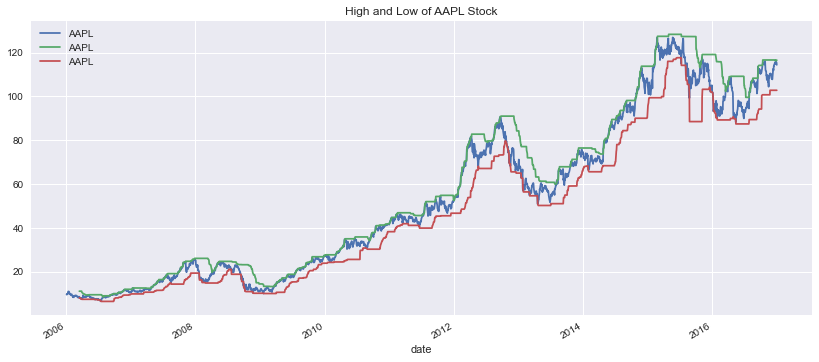

In [15]:
apple_ticker = 'AAPL'
lookback_days = 50
lookback_high, lookback_low = get_high_lows_lookback(high, low, lookback_days)

#project_helper.plot_high_low(

close[apple_ticker].plot(figsize=(14, 6))
lookback_high[apple_ticker].plot(figsize=(14, 6))
lookback_low[apple_ticker].plot(figsize=(14, 6))
plt.legend()
plt.title('High and Low of {} Stock'.format(apple_ticker))
sns.despine()
fig.tight_layout()

## Compute Long and Short Signals
Using the generated indicator of highs and lows, create long and short signals using a breakout strategy. Implement $get_long_short$ to generate the following signals:

| Signal | Condition |
|----|------|
| -1 | Low > Close Price |
| 1  | High < Close Price |
| 0  | Otherwise |

In this chart, **Close Price** is the _close_ parameter. _Low_ and _High_ are the values generated from $\text{get_high_lows_lookback}$, the _lookback_high_ and _lookback_low_ parameters.

In [16]:
def get_long_short(close, lookback_high, lookback_low):
    """
    Generate the signals long, short, and do nothing.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    
    Returns
    -------
    long_short : DataFrame
        The long, short, and do nothing signals for each ticker and date
    """    
    return (lookback_high < close).astype(int) - (lookback_low > close).astype(int)



### View Data
Let's compare the signals we generated against the close prices. This chart will show a lot of signals. Too many in fact. That is why we will talk about filtering the redundant signals in the next problem. Note that the upwards vertical lines denote the long positions, while the backwards vertical lines denote the short positions.

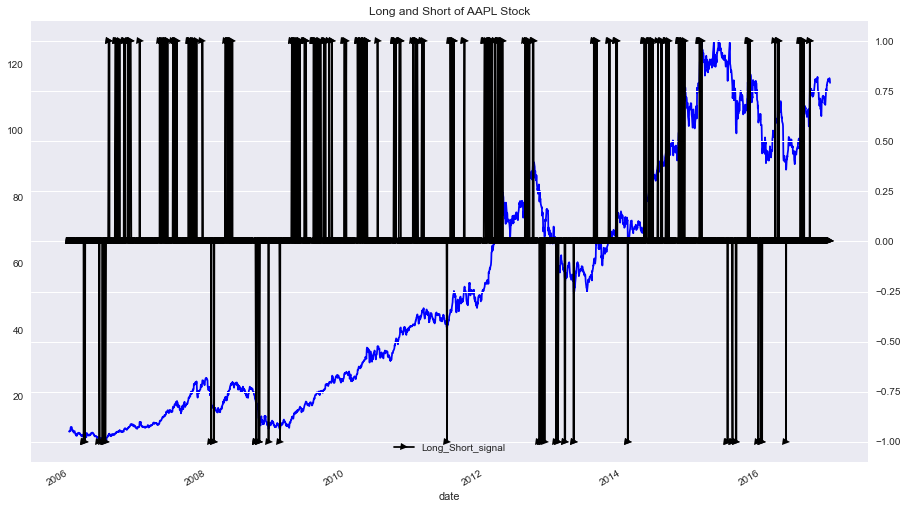

In [17]:
signal = get_long_short(close, lookback_high, lookback_low)

#project_helper.plot_signal(
    
close[apple_ticker].plot(figsize=(15, 9), color='b')
signal[apple_ticker].plot(secondary_y=True, color='k', style='>-')
plt.title('Long and Short of {} Stock'.format(apple_ticker))
plt.legend(['Long_Short_signal'])
sns.despine()
fig.tight_layout()

## Filter Signals
As we could see, that was a lot of repeated signals! If we're already shorting a stock, having an additional signal to short a stock isn't helpful for this strategy. This also applies to additional long signals when the last signal was long.

Now we are goig to implement the function $\text{filter_signals}$ to filter out repeated long or short signals within the _lookahead_days_. If the previous signal was the same, we change the signal to $0$ (do nothing signal). For example, say we have a single stock time series that is

$[1, 0, 1, 0, 1, 0, -1, -1]$

Running the function $\text{filter_signals}$ with a lookahead of 3 days should turn those signals into

$[1, 0, 0, 0, 1, 0, -1, 0]$

We will also nee a temporary function $\text{clear_signals}$. This function will remove all signals within a window after the last signal. For example, say we are using a windows size of 3 with $\text{clear_signals}$. It would turn the Series of long signals

$[0, 1, 0, 0, 1, 1, 0, 1, 0]$

into

$[0, 1, 0, 0, 0, 1, 0, 0, 0]$

$\text{clear_signals}$ only takes a Series of the same type of signals, where $1$ is the signal and $0$ is no signal. It can't take a mix of long and short signals. Using this function,  we will implement $\text{filter_signals}$. 


In [18]:
def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]

    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals).astype(np.int), signals.index)


def filter_signals(signal, lookahead_days):
    """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
    """
    long_position = (signal==1).astype(int)
    short_position = (signal==-1).astype(int)
    
    long_position = long_position.apply(lambda signals: clear_signals(signals, lookahead_days))
    short_position = short_position.apply(lambda signals: clear_signals(signals, lookahead_days))
        
    return long_position + short_position*(-1)

### View Data
Let's now view the same chart as before, but with the redundant signals removed.

In [19]:
signal_5 = filter_signals(signal, 5)
signal_10 = filter_signals(signal, 10)
signal_20 = filter_signals(signal, 20)

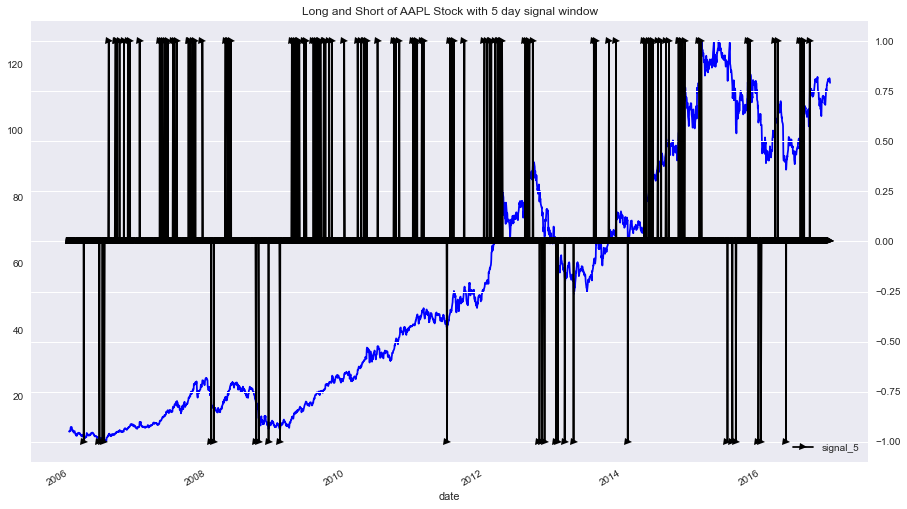

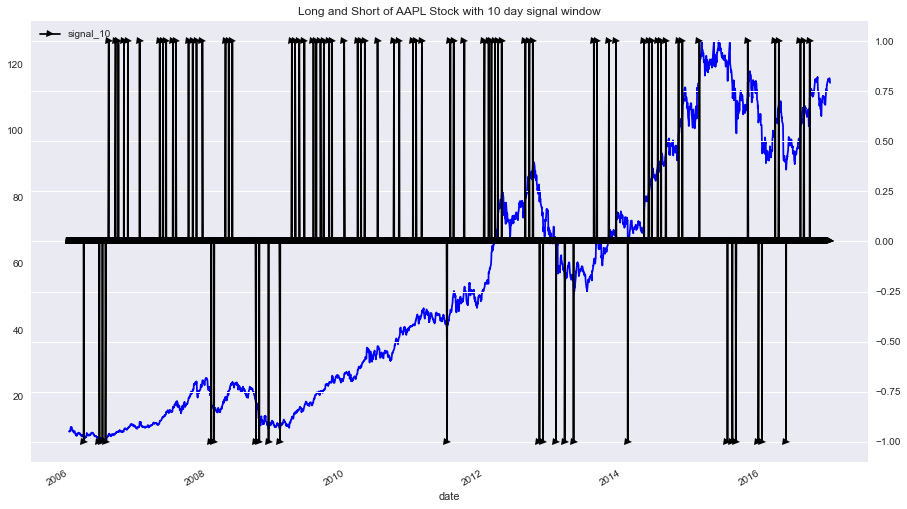

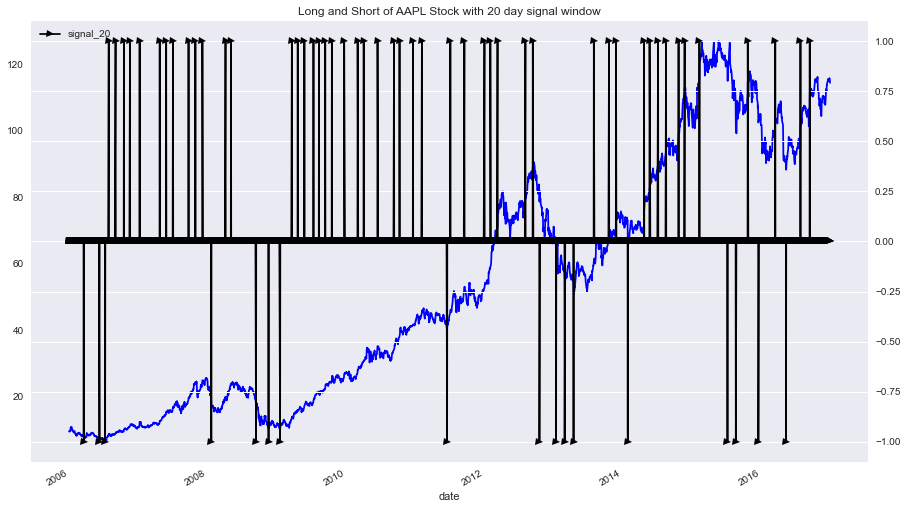

In [20]:
for signal_data, signal_days, signal in [(signal_5, 5, 'signal_5'), (signal_10, 10, 'signal_10'), (signal_20, 20, 'signal_20')]:
    close[apple_ticker].plot(figsize=(15, 9), color='b')
    signal_data[apple_ticker].plot(secondary_y=True, color='k', style='>-')
    plt.title('Long and Short of {} Stock with {} day signal window'.format(apple_ticker, signal_days))
    plt.legend([signal])
    sns.despine()
    fig.tight_layout()
    plt.show()


## Lookahead Close Prices
With the trading signal done, we can start working on evaluating how many days to short or long the stocks. We will now implement $\text{get_lookahead_prices}$ to get the close price days ahead in time. We will get the number of days from the variable _lookahead_days_. We will ultimately use the lookahead prices to calculate future returns.

In [21]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    
    return close.shift(-lookahead_days)

### View Data
Using the $\text{get_lookahead_prices}$ function, let's generate lookahead closing prices for 5, 10, and 20 days.

Let's also chart a subsection of a few months of the Apple stock instead of years. This will allow us to view the differences between the 5, 10, and 20 day lookaheads. Otherwise, they will mesh together when looking at a chart that is zoomed out.

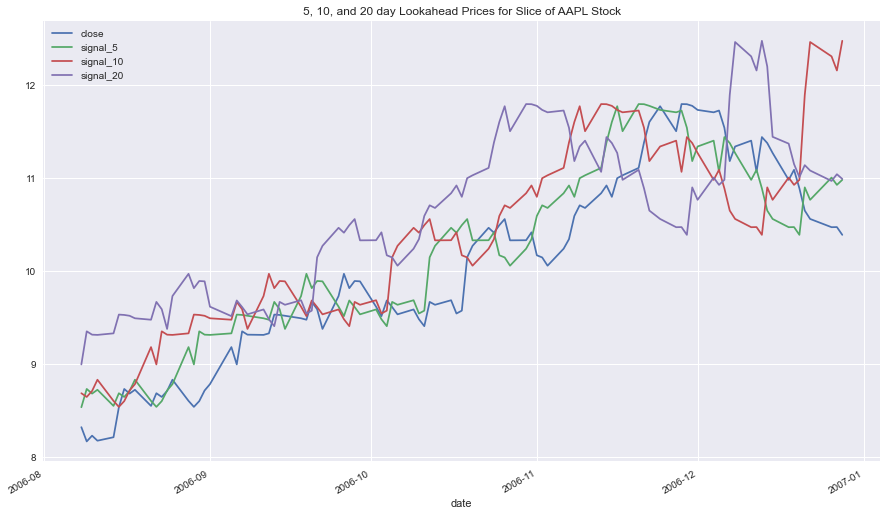

In [22]:
lookahead_5 = get_lookahead_prices(close, 5)
lookahead_10 = get_lookahead_prices(close, 10)
lookahead_20 = get_lookahead_prices(close, 20)
plt.figure()
close[apple_ticker].iloc[150:250].plot(figsize=(15, 9))
lookahead_5[apple_ticker].iloc[150:250].plot()
lookahead_10[apple_ticker].iloc[150:250].plot()
lookahead_20[apple_ticker].iloc[150:250].plot()
plt.title('5, 10, and 20 day Lookahead Prices for Slice of {} Stock'.format(apple_ticker))
plt.legend(['close', 'signal_5', 'signal_10', 'signal_20'])
sns.despine()
fig.tight_layout()
plt.show()


## Lookahead Price Returns
Now we implement $\text{get_return_lookahead}$ to generate the log price return between the closing price and the lookahead price.

In [23]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """    
    
    return np.log(lookahead_prices) - np.log(close)

### View Data
Using the same lookahead prices and same subsection of the Apple stock from the previous task, we'll view the lookahead returns.


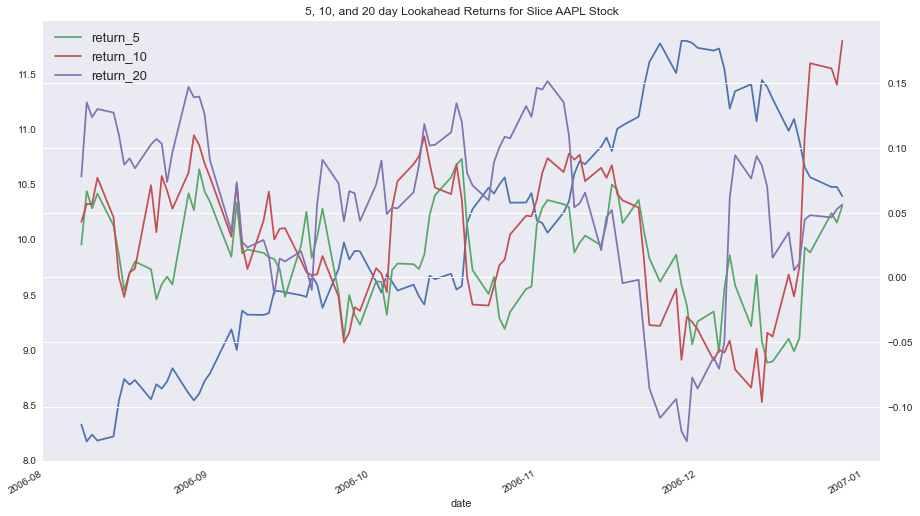

In [24]:
price_return_5 = get_return_lookahead(close, lookahead_5)
price_return_10 = get_return_lookahead(close, lookahead_10)
price_return_20 = get_return_lookahead(close, lookahead_20)
plt.figure(figsize=(15, 9))
close[apple_ticker].iloc[150:250].plot()
price_return_5[apple_ticker].iloc[150:250].plot(secondary_y=True)
price_return_10[apple_ticker].iloc[150:250].plot(secondary_y=True)
price_return_20[apple_ticker].iloc[150:250].plot(secondary_y=True)
plt.title('5, 10, and 20 day Lookahead Returns for Slice {} Stock'.format(apple_ticker))
plt.legend(['return_5', 'return_10', 'return_20'], fontsize=13)
sns.despine()
fig.tight_layout()
plt.show()

## Compute the Signal Return
Using the price returns, we will generate the signal returns.

In [25]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_return : DataFrame
        Signal returns for each ticker and date
    """
    
    return signal*lookahead_returns

### View Data
We are using the previous lookahead prices to view the signal returns. Just like before, the axis for the signal returns is on the right side of the chart.

Looking at the chart, we see how signal returns are distributed around 0.

In [26]:
signal_return_5 = get_signal_return(signal_5, price_return_5)
signal_return_10 = get_signal_return(signal_10, price_return_10)
signal_return_20 = get_signal_return(signal_20, price_return_20)

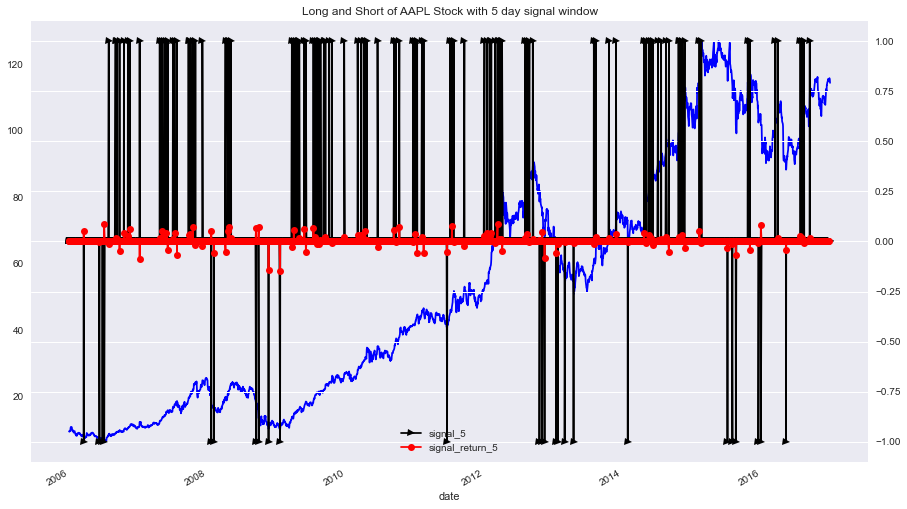

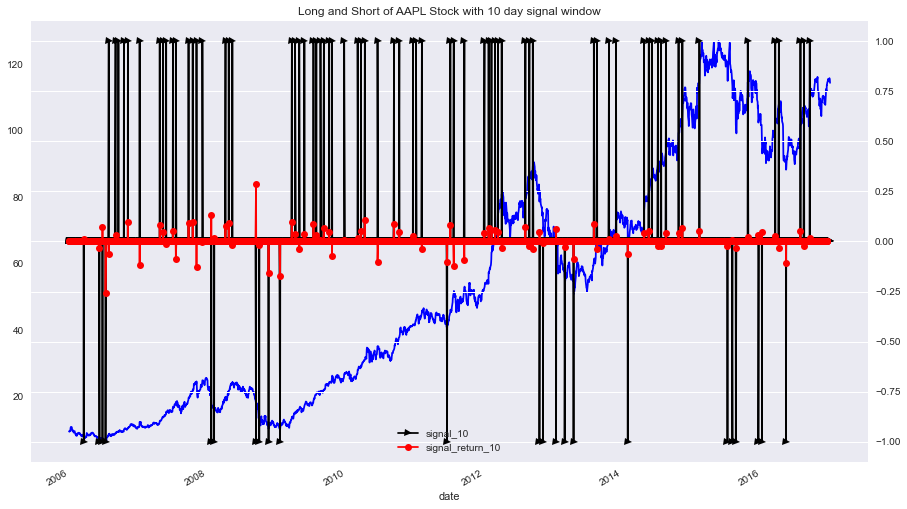

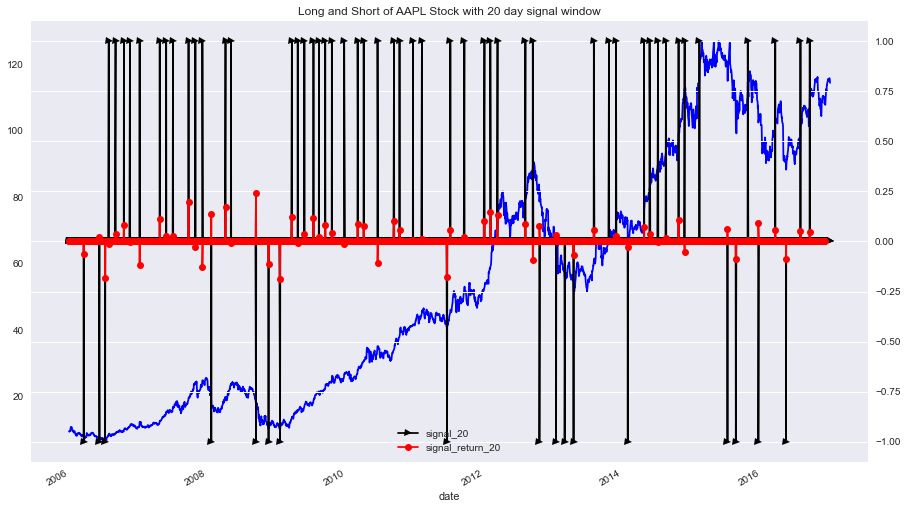

In [27]:
for signal_data, signal_return, signal_days, legend in [(signal_5, signal_return_5, 5, ['signal_5', 'signal_return_5']), (signal_10, signal_return_10, 10, ['signal_10', 'signal_return_10']), (signal_20, signal_return_20, 20, ['signal_20', 'signal_return_20'])]:
    plt.figure(figsize=(15, 9))
    close[apple_ticker].plot(color='b')
    signal_data[apple_ticker].plot(secondary_y=True, color='k', style='>-')
    signal_return[apple_ticker].plot(secondary_y=True, color='r', style='o-')
    plt.title('Long and Short of {} Stock with {} day signal window'.format(apple_ticker, signal_days))
    plt.legend(legend)
    sns.despine()
    fig.tight_layout()
    plt.show()

## Test for Significance
### Histogram
Here we plot a histogram of the signal return values.

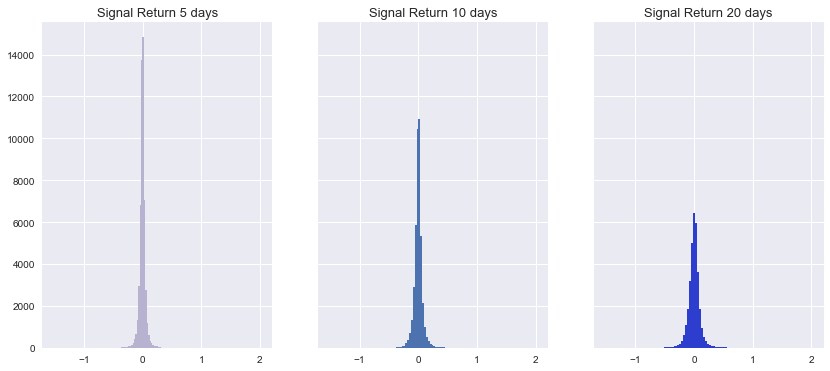

In [28]:
figh, axh = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharex=True, sharey=True)
signal_return_5.stack()[signal_return_5.stack()!=0].dropna().hist(bins=100, ax=axh[0], color='#B6B2CF')
axh[0].set_title('Signal Return 5 days', fontsize=13)
signal_return_10.stack()[signal_return_10.stack()!=0].dropna().hist(bins=100, ax=axh[1])
axh[1].set_title('Signal Return 10 days', fontsize=13)
signal_return_20.stack()[signal_return_20.stack()!=0].dropna().hist(bins=100, ax=axh[2], color='#2D3ECF')
axh[2].set_title('Signal Return 20 days', fontsize=13)
sns.despine()
fig.tight_layout()
plt.show()


From the histogram charts above, we can notice that the distribution of the signal returns are alomost normally distributed. This is a good news for expecting profits with this strategy. However, we need to make sure that this empirical observation holds.

For that, we will need to check if there is actually a presence of outliers among the stocks which is visually impossible to spot. Removing the outliers will help us avoid misleading signals and make sure that all the remaining stocks exhibit true signal.

## Outliers

When the distribution or signal returns looks more like normal distribution, it also means it's closer to reality. It might be more reliable and we can use it to generate consistent returns. The consistency matters more here because as an investor one can long the tickers that produce profits and at the same time one could short the tickers that are likely to generate losses. If one can be sure about that, their portfolio can still be profitable just betting on consistency of the strategy, hence __normal distribution is preferrable__. On the other hand, outliers could just simply be there due to some error in data input, so it's necessary to check their existence and them in order to not skew the signal.


## Kolmogorov-Smirnov Test
We need to find the stocks that might be causing unseen outlying returns. We'll use the Kolmogorov-Smirnov Test or KS-Test. This test will be applied to each ticker's signal returns where a long or short signal exits.

In [29]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_10 = signal_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()

# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

# View some of the data
long_short_signal_returns_5.head(10)

,ticker,signal_return
0,A,-0.014412
1,ABC,-0.005506
2,ADBE,-0.011071
3,AVB,-0.009785
4,BA,0.015133
5,BAC,-0.001284
6,BBY,-0.043056
7,BEAM,0.004511
8,BMRN,-0.058427
9,BXP,-0.008054


This gives us the data to use in the KS-Test.

Now it's time to implement the function $\text{calculate_kstest}$ to use Kolmogorov-Smirnov test (KS test) between a distribution of stock returns (the input dataframe in this case) and each stock's signal returns. 

 We will compare the signal return of the individual tickers against a normal distribution whose parameters - mean and standard deviation - are computed from all tickers.

In [30]:
from scipy.stats import kstest


def calculate_kstest(long_short_signal_returns):
    """
    Calculate the KS-Test against the signal returns with a long or short signal.
    
    Parameters
    ----------
    long_short_signal_returns : DataFrame
        The signal returns which have a signal.
        This DataFrame contains two columns, "ticker" and "signal_return"
    
    Returns
    -------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    """
    dict_ks = {}
    dict_pval = {}
    normal_args = (np.mean(long_short_signal_returns),np.std(long_short_signal_returns,ddof=0))
    
    for _, j in enumerate(long_short_signal_returns.groupby("ticker")):
        dict_ks[j[0]], dict_pval[j[0]] = kstest(j[1].signal_return, 'norm', normal_args)
    
    return pd.Series(dict_ks), pd.Series(dict_pval)

### View Data
Using the signal returns we created above, let's calculate the ks and p values.

In [31]:
ks_values_5, p_values_5 = calculate_kstest(long_short_signal_returns_5)
ks_values_10, p_values_10 = calculate_kstest(long_short_signal_returns_10)
ks_values_20, p_values_20 = calculate_kstest(long_short_signal_returns_20)

print('ks_values_5')
print(ks_values_5.head(10))
print('p_values_5')
print(p_values_5.head(10))

ks_values_5
A       0.127673
AAL     0.156518
AAP     0.178151
AAPL    0.204539
ABC     0.195802
ABT     0.261635
ACE     0.260863
ACI     0.200192
ACN     0.244515
ADBE    0.141454
dtype: float64
p_values_5
A       3.199065e-02
AAL     1.031893e-02
AAP     1.154172e-03
AAPL    4.611566e-05
ABC     1.661432e-04
ABT     3.925196e-07
ACE     2.980551e-06
ACI     8.879366e-04
ACN     5.834241e-06
ADBE    2.034537e-02
dtype: float64


## Find Outliers
With the ks and p values calculate, let's find which symbols are the outliers. For that, we will implement the $\text{find_outliers}$ function to find the following outliers:
- Symbols that pass the null hypothesis with a p-value less than _pvalue_threshold_ **AND** with a KS value above _ks_threshold_.

Hence, our function should return symbols that meet both requirements above.

In [32]:
list_tickers = []
for i in range(len(p_values_5)):
    if p_values_5[p_values_5.index[i]] < 0.05 and ks_values_5[ks_values_5.index[i]] > 0.8:
        list_tickers.append(p_values_5.index[i])
        
        
print(list_tickers) 

[]


In [33]:
def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    """
    Find outlying symbols using KS values and P-values
    
    Parameters
    ----------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    ks_threshold : float
        The threshold for the KS statistic
    pvalue_threshold : float
        The threshold for the p-value
    
    Returns
    -------
    outliers : set of str
        Symbols that are outliers
    """
    
    return set(ks_values[ks_values > ks_threshold].index).intersection(p_values[p_values < pvalue_threshold].index)

### View Data
Using the $\text{find_outliers}$ function you implemented, let's see what we found.

In [34]:
ks_threshold = 0.8
outliers_5 = find_outliers(ks_values_5, p_values_5, ks_threshold)
outliers_10 = find_outliers(ks_values_10, p_values_10, ks_threshold)
outliers_20 = find_outliers(ks_values_20, p_values_20, ks_threshold)

outlier_tickers = outliers_5.union(outliers_10).union(outliers_20)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

0 Outliers Found:



We have thus foud 0 outliers as show by the histogram of the distribution of signal returns. This means that our selected univers of stock was very well chosen. Besides, the data cleaning we performed at the very beggining  was very effectif. 

We have finished the research phase this breakout strategy. We have a portfolio of 500 stoks that could be profitable by longing the tickers that produce profits and at the same time shorting the tickers that are likely to generate losses.

Note that this is one step among the whole cycle of quant research activitie as shown early by the graph cycle of quant researcher activities before validating a strategy. 

More to come...

